# Final Branch Coverage (Multi Parameter) 

This is a Notebook used to determine if adaptive parameter control have any effect on the final branch coverage.

It is divided into the main sections:

- Prior Predictive Check
- Model specification
- Data analysis

# Prior Predictive Check

Sampling: [a_bar, a_offset, b_offset, g_offset, sigma_a, sigma_b, sigma_g, theta]


<Figure size 400x300 with 0 Axes>

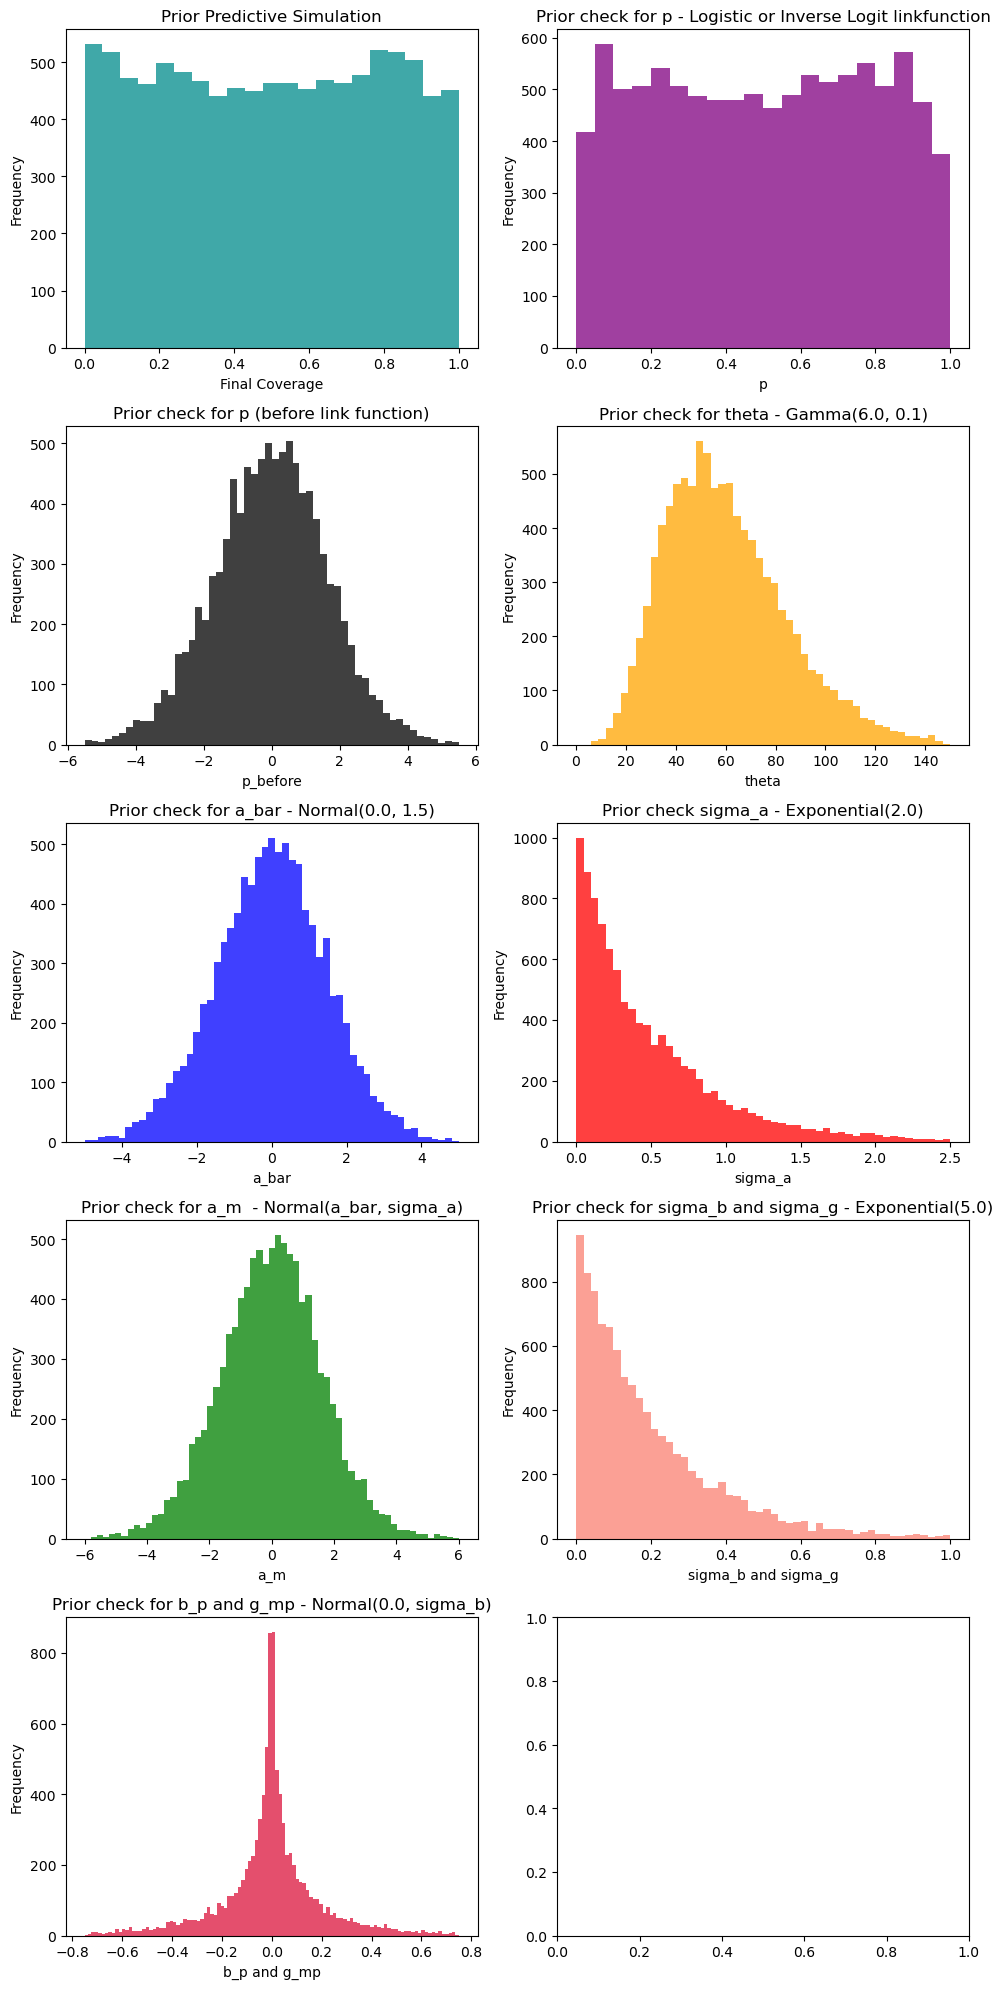

In [2]:
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact, FloatSlider
from utils.prior_check_helper import HistogramPlot, plot_histograms

def perform_prior_check(s_a, s_b, s_g, a_bar_mu, a_bar_sigma):
    with pm.Model():
        # Global Intercept for modules
        a_bar = pm.Normal('a_bar', mu=a_bar_mu, sigma=a_bar_sigma)
        
        # Standard deviation for Module, Parameter and Interaction effects
        sigma_a = pm.Exponential('sigma_a', s_a)
        sigma_b = pm.Exponential('sigma_b', s_b)
        sigma_g = pm.Exponential('sigma_g', s_g)
        
        # Modules, Parameters and Interactions effects
        # With non-centered parameterizations (helps with divergences) 
        a_offset = pm.Normal('a_offset', mu=0, sigma=1)
        a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

        b_offset = pm.Normal('b_offset', mu=0, sigma=1)
        b_p = pm.Deterministic('b_p', sigma_b * b_offset)

        g_offset = pm.Normal('g_offset', mu=0, sigma=1)
        g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)
        

        # Link function (logit), from unbounded to (0,1) probability
        pm.Deterministic('p_before', (a_m + b_p + g_mp))        
        pm.Deterministic('p', pm.math.sigmoid(a_m + b_p + g_mp))
        
        # Gamma distriubtion for theta (dispersion/spread) 
        pm.Gamma('theta', alpha=6, beta= 0.1)

        # Sample priors from the model
        idata = pm.sample_prior_predictive(samples=10000)


    # Fetch and flatten priors
    prior_p = idata.prior['p'].values.flatten()
    prior_theta = idata.prior['theta'].values.flatten()


    # Use alpha and beta as parameters for a Beta distribution to sample observations
    simulated_observations = np.random.beta(a=prior_p * prior_theta, b=(1 - prior_p) * prior_theta)


    # Plot histogram of observations 
    plt.figure(figsize=(4, 3))
    observation_plot = HistogramPlot(simulated_observations,'Prior Predictive Simulation', 'Final Coverage',
                                        'darkcyan', bin_range=(0, 1.0))

    # Plot priors for the different parameters
    plots = [
        observation_plot,
        HistogramPlot(idata.prior['p'].values.flatten(), 'Prior check for p - Logistic or Inverse Logit linkfunction', 'p', 'purple', bin_range=(0, 1), bins=20),
        HistogramPlot(idata.prior['p_before'].values.flatten(), 'Prior check for p (before link function)', 'p_before', 'black', bin_range=(-5.5, 5.5)),
        HistogramPlot(idata.prior['theta'].values.flatten(), 'Prior check for theta - Gamma(6.0, 0.1)', 'theta', 'orange', bin_range= (0,150)),
        HistogramPlot(idata.prior['a_bar'].values.flatten(), 'Prior check for a_bar - Normal(0.0, 1.5)', 'a_bar', 'blue', bin_range=(-5,5)),
        HistogramPlot(idata.prior['sigma_a'].values.flatten(), 'Prior check sigma_a - Exponential(2.0)', 'sigma_a', 'red', bin_range=(0,2.5)),
        HistogramPlot(idata.prior['a_m'].values.flatten(), 'Prior check for a_m  - Normal(a_bar, sigma_a)', 'a_m', 'green', bin_range=(-6, 6)),
        HistogramPlot(idata.prior['sigma_b'].values.flatten(), 'Prior check for sigma_b and sigma_g - Exponential(5.0)', 'sigma_b and sigma_g', 'salmon', bin_range=(0, 1)),
        HistogramPlot(idata.prior['b_p'].values.flatten(), 'Prior check for b_p and g_mp - Normal(0.0, sigma_b)', 'b_p and g_mp', 'crimson', bin_range=(-0.75, 0.75)),
    ]

    plot_histograms(plots, 5, 2, figsize=(10,20), save_img=True, prefix_name="final_coverage_single", output_folder="prior_checks/final_coverage_single")


perform_prior_check(2, 5, 5, 0, 1.5)


### UNCOMMENT FOR INTERACTIVE PRIOR CHECK ###

#s_a = FloatSlider(value=2, min=0.5, max=6, step=0.1, description='Sigma_alpha (sigma_a):')
#s_b = FloatSlider(value=5, min=0.5, max=6, step=0.1, description='Sigma_beta (sigma_b):')
#s_g = FloatSlider(value=5, min=0.5, max=6, step=0.1, description='Sigma_gamma (sigma_g):')
#a_bar_mu = FloatSlider(value=0, min=-2, max=2, step=0.1, description='alpha bar mu (a_bar_mu):')
#a_bar_sigma = FloatSlider(value=1.5, min=0, max=3, step=0.1, description='alpha bar sigma (a_bar_sigma):')

#interact(perform_prior_check, s_a=s_a, s_b=s_b, s_g=s_g, a_bar_mu=a_bar_mu, a_bar_sigma=a_bar_sigma, )

# Model specification

### Data Preperation

In [3]:
import pymc as pm
import pandas as pd
from utils.design_matrix_creator import get_design_matricies

# Load data
data = pd.read_csv("../multi_parameter/combined_data/statistics.csv")

# Create design matricies that contain dummy variables for each module, parameter and interaction.
observation_matrix, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(data, 'Coverage')

Module Matrix shape: (16080, 24)
Parameter Matrix shape: (16080, 66)
Interaction Matrix shape: (16080, 1584)
Observation Matrix shape: (16080, 1)


In [ ]:
with pm.Model() as model:
    # Global Intercept for Modules
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.5)
    
    # Standard deviations for Module, Parameter and Interaction effects
    sigma_a = pm.Exponential('sigma_a', 2.0)
    sigma_b = pm.Exponential('sigma_b', 5.0)
    sigma_g = pm.Exponential('sigma_g', 5.0)
    
    # Modules, Parameters and Interactions effects
    # With non-centered parameterizations (helps with divergences)
    a_offset = pm.Normal('a_offset', mu=0, sigma=1, shape=24)
    a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

    b_offset = pm.Normal('b_offset', mu=0, sigma=1, shape=66)
    b_p = pm.Deterministic('b_p', sigma_b * b_offset)

    g_offset = pm.Normal('g_offset', mu=0, sigma=1, shape=1584)
    g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)

    
    # Activate the correct module, parameter and interaction for each run
    logit_a = pm.math.dot(module_matrix, a_m)
    logit_b = pm.math.dot(parameter_matrix, b_p)
    logit_g = pm.math.dot(interaction_matrix, g_mp)

    # Link function (logit), from unbounded to (0,1) probability
    p = pm.Deterministic('p', pm.math.sigmoid(logit_a + logit_b + logit_g))
    
    # Beta distribution likelihood with parameters alpha and beta
    theta = pm.Gamma('theta', alpha=6, beta= 0.1) # Dispersion/spread parameter
    Y_obs = pm.Beta('Y_obs', alpha=p*theta, beta=(1-p)*theta, observed=observation_matrix['Coverage'])
    
    # Sample from the model
    trace = pm.sample(5000, chains=4,return_inferencedata=True, progressbar=True, target_accept=0.95)
    log_lik = pm.compute_log_likelihood(trace)
    
print("Model building complete.")

### Save the results

In [ ]:
import arviz as az

az.to_netcdf(trace, "final_coverage_model_multi_parameter.nc")

# Data analysis


### Generate summary object (without transformations)

In [4]:
import arviz as az
from utils.inference_data_helper import create_inference_data_from_trace
import pandas as pd
pd.set_option('display.max_rows', 2000)

trace = az.from_netcdf("../multi_parameter/final_coverage_model_multi_parameter.nc") 
variable_list = ['a_m', 'b_p', 'g_mp', 'a_bar', 'sigma_a', 'sigma_b', 'sigma_g', 'theta']
transformations = {}

idata = create_inference_data_from_trace(trace, variable_list, transformations)
summary = az.summary(idata, variable_list, hdi_prob=0.89)

### Replace numeric identifiers with descriptive identifiers

In [5]:
from utils.summary_table_formatting import update_table, get_replacement_list
from utils.design_matrix_creator import get_design_matricies

_, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(pd.read_csv("../multi_parameter/combined_data/statistics.csv"), 'Coverage')

module_names = get_replacement_list(module_matrix.columns)
parameter_names = get_replacement_list(parameter_matrix.columns)
interaction_names = get_replacement_list(interaction_matrix.columns)

update_table(summary, 'a_m', replacement=module_names)
update_table(summary, 'b_p', replacement=parameter_names)
update_table(summary, 'g_mp', replacement=interaction_names)

summary.sort_values(by='mean', ascending=True)

Module Matrix shape: (16080, 24)
Parameter Matrix shape: (16080, 66)
Interaction Matrix shape: (16080, 1584)
Observation Matrix shape: (16080, 1)


mean     sd  hdi_5.5%  \
a_m[packages]                                       -2.882  0.025    -2.922   
a_m[cmd]                                            -2.488  0.022    -2.522   
a_m[dict_unpacking]                                 -1.785  0.018    -1.814   
a_m[signals]                                        -1.418  0.016    -1.444   
a_m[python]                                         -1.216  0.015    -1.240   
a_m[return_from_generator]                          -0.975  0.015    -0.998   
a_m[py_base]                                        -0.911  0.014    -0.934   
a_m[positional_validation]                          -0.850  0.014    -0.873   
a_m[journaling]                                     -0.741  0.014    -0.763   
g_mp[return_from_generator x ChromLen|TestDelet...  -0.179  0.056    -0.264   
g_mp[return_from_generator x Elite|TestChangeProb]  -0.138  0.052    -0.218   
a_m[lazy_import]                                    -0.117  0.013    -0.139   
g_mp[return_from_generator x ChromLen|Crossover]    -0.101  0.048    -0.178   
g_mp[return_from_generator x Crossover|RandPert]    -0.099  0.048    -0.176   
g_mp[return_from_generator x Elite|TourSize]        -0.097  0.048    -0.172   
g_mp[yield_from x Elite|TestChangeProb]             -0.063  0.045    -0.135   
g_mp[return_from_generator x ChangeParamProb|St...  -0.063  0.046    -0.136   
g_mp[return_from_generator x StatemInsertProb|T...  -0.062  0.046    -0.134   
g_mp[return_from_generator x ChromLen|Pop]          -0.061  0.045    -0.130   
g_mp[return_from_generator x Pop|TestInsertionP...  -0.061  0.045    -0.133   
g_mp[return_from_generator x Pop|TestChangeProb]    -0.060  0.046    -0.136   
g_mp[return_from_generator x ChromLen|TourSize]     -0.059  0.045    -0.129   
g_mp[return_from_generator x ChromLen|TestChang...  -0.059  0.045    -0.129   
g_mp[return_from_generator x TestDeleteProb|Tes...  -0.059  0.046    -0.134   
g_mp[return_from_generator x StatemInsertProb|T...  -0.059  0.046    -0.131   
g_mp[return_from_generator x ChangeParamProb|Pop]   -0.059  0.045    -0.131   
g_mp[return_from_generator x Elite|Pop]             -0.058  0.046    -0.130   
g_mp[return_from_generator x ChangeParamProb|Te...  -0.057  0.045    -0.131   
g_mp[py_base x Crossover|TestInsertProb]            -0.052  0.045    -0.125   
g_mp[yield_from x Elite|Pop]                        -0.051  0.044    -0.121   
g_mp[yield_from x Crossover|TestInsertProb]         -0.045  0.044    -0.116   
g_mp[yield_from x Pop|TourSize]                     -0.045  0.045    -0.113   
g_mp[yield_from x Crossover|RandPert]               -0.044  0.044    -0.115   
g_mp[py_base x ChromLen|Pop]                        -0.043  0.045    -0.116   
g_mp[yield_from x StatemInsertProb|TestDeleteProb]  -0.043  0.044    -0.114   
g_mp[py_base x ChromLen|StatemInsertProb]           -0.043  0.045    -0.114   
g_mp[return_from_generator x ChangeParamProb|Cr...  -0.039  0.045    -0.111   
g_mp[yield_from x TestChangeProb|TestInsertionP...  -0.038  0.044    -0.109   
g_mp[positional_validation x ChangeParamProb|Ra...  -0.037  0.044    -0.105   
g_mp[positional_validation x Pop|TourSize]          -0.037  0.045    -0.109   
g_mp[positional_validation x Elite|RandPert]        -0.037  0.044    -0.109   
g_mp[positional_validation x StatemInsertProb|T...  -0.037  0.044    -0.110   
g_mp[positional_validation x Pop|TestInsertProb]    -0.037  0.044    -0.109   
g_mp[positional_validation x ChangeParamProb|Te...  -0.037  0.044    -0.112   
g_mp[positional_validation x Crossover|StatemIn...  -0.037  0.045    -0.111   
g_mp[positional_validation x Crossover|TourSize]    -0.037  0.044    -0.107   
g_mp[yield_from x ChangeParamProb|ChromLen]         -0.037  0.044    -0.108   
g_mp[positional_validation x Pop|TestDeleteProb]    -0.037  0.045    -0.110   
g_mp[positional_validation x TestChangeProb|Tou...  -0.037  0.045    -0.108   
g_mp[positional_validation x StatemInsertProb|T...  -0.036  0.045    -0.106   
g_mp[positional_validatio

### Plot the prior distributions and their assosicated trace plots

array([[<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'b_p'}>, <Axes: title={'center': 'b_p'}>],
       [<Axes: title={'center': 'g_mp'}>,
        <Axes: title={'center': 'g_mp'}>],
       [<Axes: title={'center': 'a_bar'}>,
        <Axes: title={'center': 'a_bar'}>],
       [<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>],
       [<Axes: title={'center': 'sigma_b'}>,
        <Axes: title={'center': 'sigma_b'}>],
       [<Axes: title={'center': 'sigma_g'}>,
        <Axes: title={'center': 'sigma_g'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

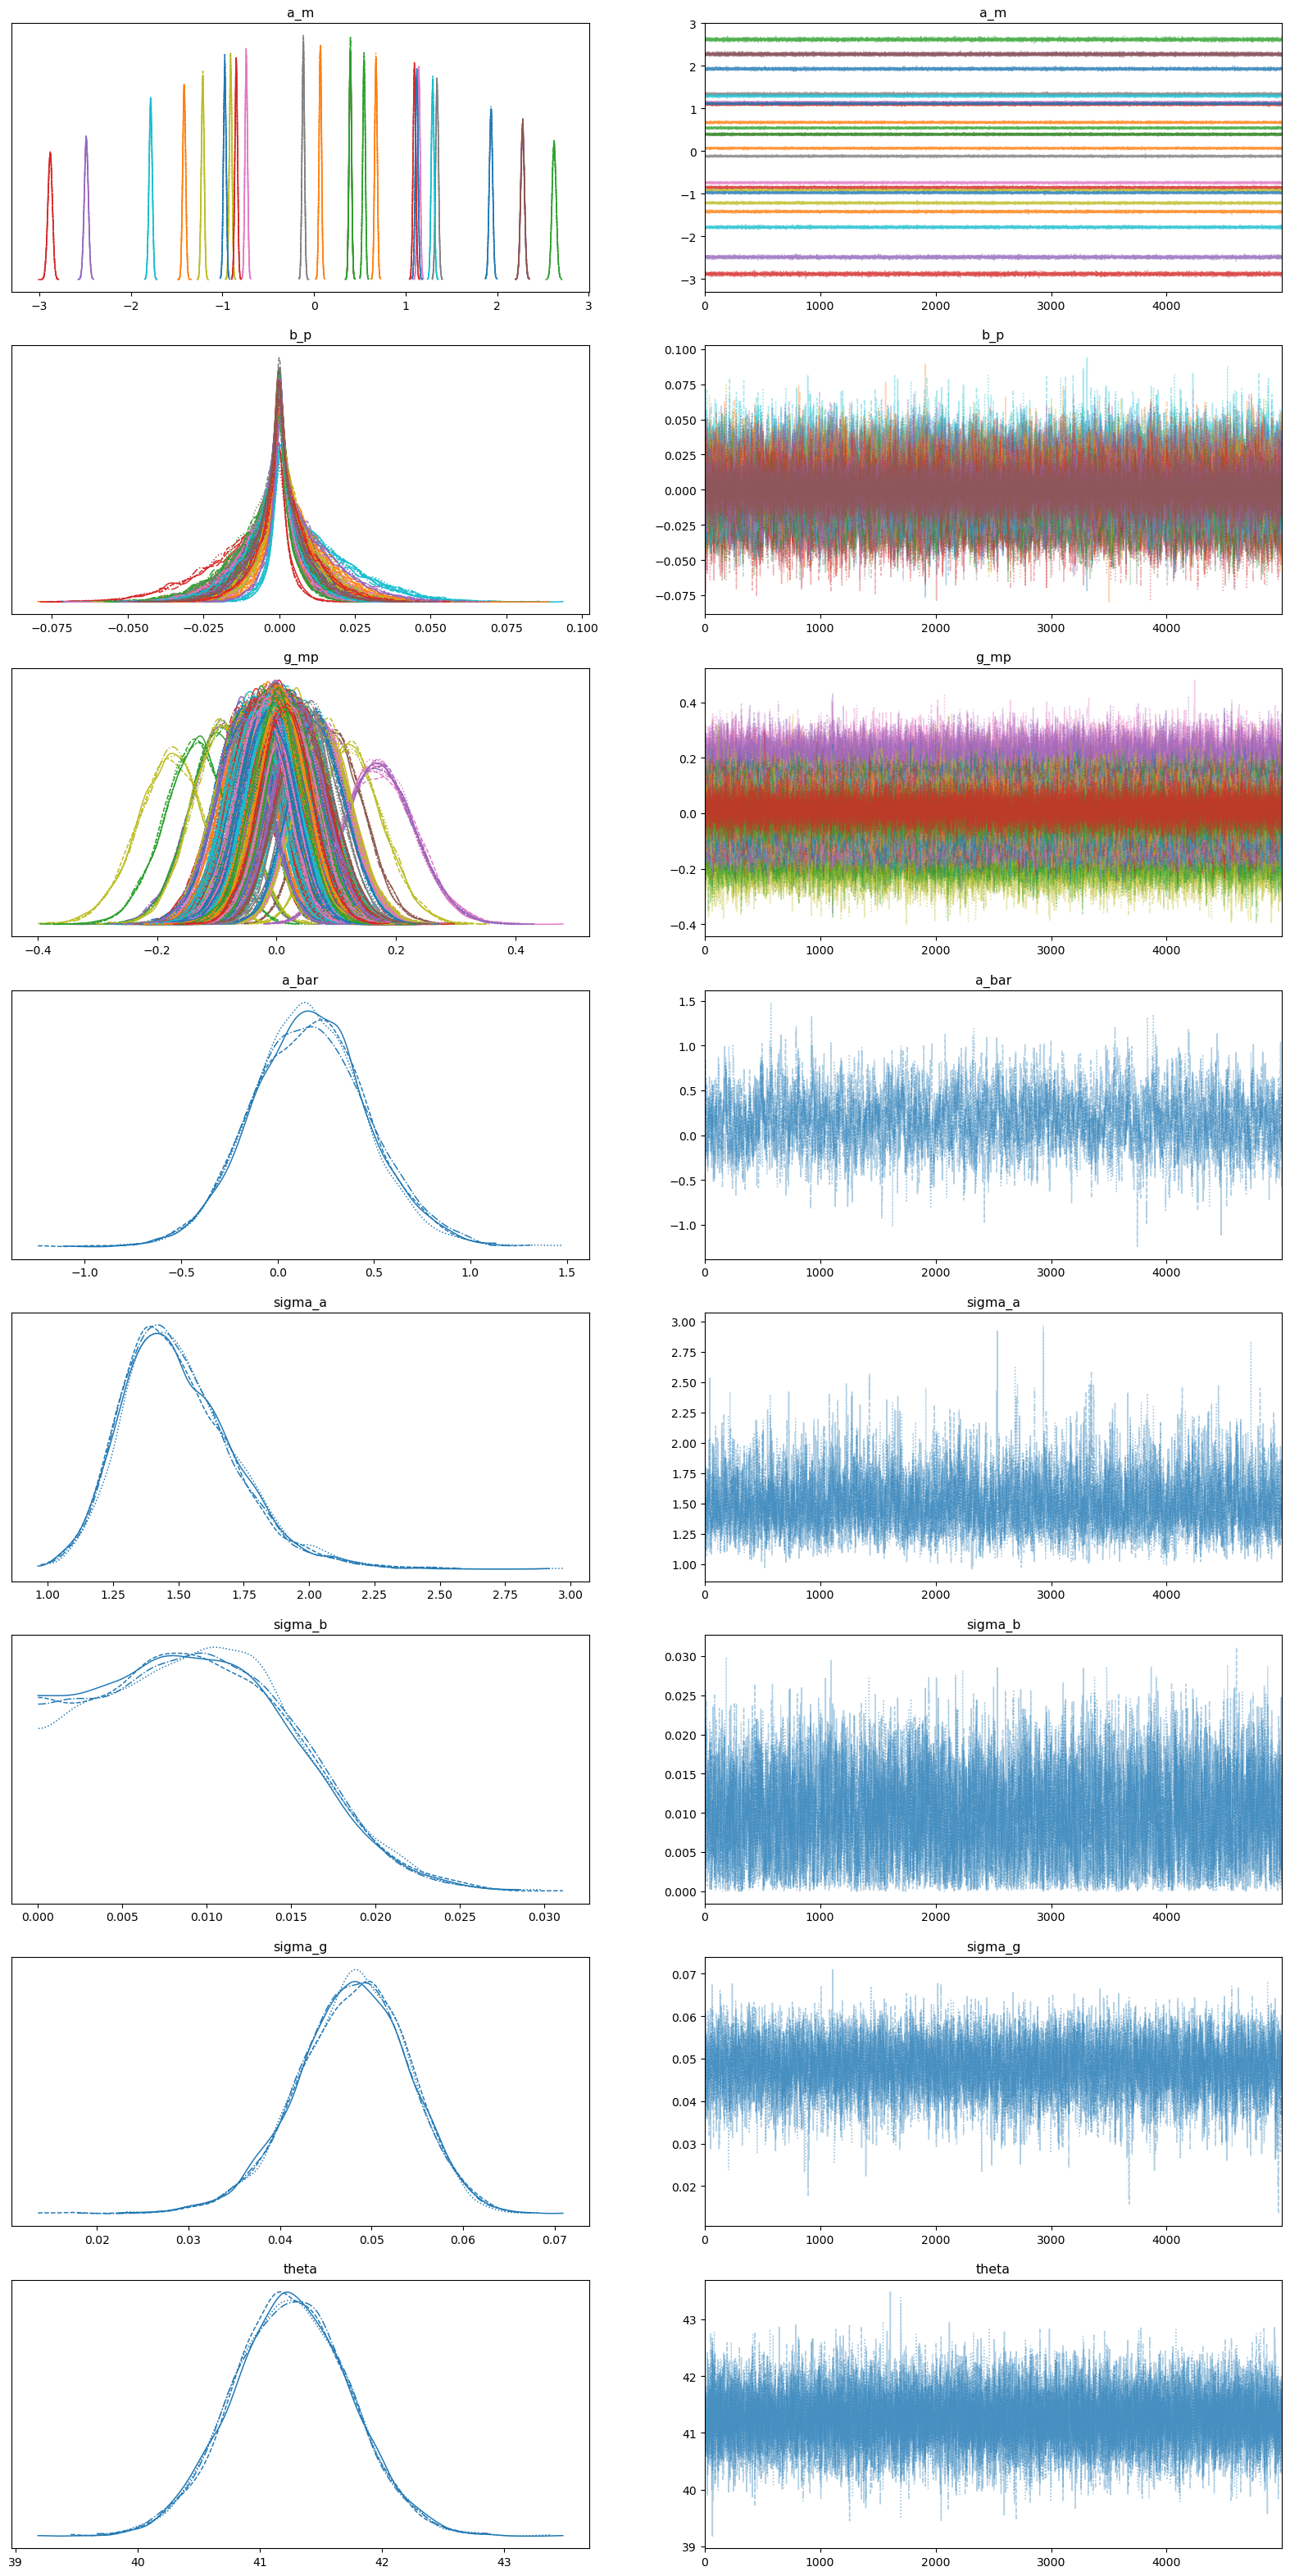

In [6]:
import matplotlib.pyplot as plt

az.plot_trace(idata, var_names=variable_list, figsize=(20, 40))

### Transformed effects

In [8]:
import arviz as az
from utils.inference_data_helper import create_inference_data_from_trace, logit_to_probability
import pandas as pd
pd.set_option('display.max_rows', 2000)  # Increase number of rows

# Example usage
trace = az.from_netcdf("../multi_parameter/final_coverage_model_multi_parameter.nc") 
variable_list = ['a_m', 'b_p', 'g_mp', 'a_bar', 'sigma_a', 'sigma_b', 'sigma_g', 'theta']
transformations = {
    'a_m': logit_to_probability,
    'b_p': logit_to_probability,
    'g_mp':logit_to_probability,
    'a_bar': logit_to_probability
}

idata_transformed = create_inference_data_from_trace(trace, variable_list, transformations)
summary_transformed = az.summary(idata_transformed, variable_list, hdi_prob=0.89)

In [9]:
from utils.summary_table_formatting import update_table, get_replacement_list
from utils.design_matrix_creator import get_design_matricies

_, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(pd.read_csv("../multi_parameter/combined_data/statistics.csv"), 'Coverage')

module_names = get_replacement_list(module_matrix.columns)
parameter_names = get_replacement_list(parameter_matrix.columns)
interaction_names = get_replacement_list(interaction_matrix.columns)

update_table(summary_transformed, 'a_m', replacement=module_names)
update_table(summary_transformed, 'b_p', replacement=parameter_names)
update_table(summary_transformed, 'g_mp', replacement=interaction_names)

summary_transformed.sort_values(by='mean', ascending=True)

Module Matrix shape: (16080, 24)
Parameter Matrix shape: (16080, 66)
Interaction Matrix shape: (16080, 1584)
Observation Matrix shape: (16080, 1)


mean     sd  hdi_5.5%  \
sigma_b                                              0.009  0.006     0.000   
sigma_g                                              0.048  0.006     0.038   
a_m[packages]                                        0.053  0.001     0.051   
a_m[cmd]                                             0.077  0.002     0.074   
a_m[dict_unpacking]                                  0.144  0.002     0.140   
a_m[signals]                                         0.195  0.003     0.191   
a_m[python]                                          0.229  0.003     0.224   
a_m[return_from_generator]                           0.274  0.003     0.269   
a_m[py_base]                                         0.287  0.003     0.282   
a_m[positional_validation]                           0.299  0.003     0.295   
a_m[journaling]                                      0.323  0.003     0.318   
g_mp[return_from_generator x ChromLen|TestDelet...   0.455  0.014     0.433   
g_mp[return_from_generator x Elite|TestChangeProb]   0.466  0.013     0.446   
a_m[lazy_import]                                     0.471  0.003     0.465   
g_mp[return_from_generator x Crossover|RandPert]     0.475  0.012     0.456   
g_mp[return_from_generator x ChromLen|Crossover]     0.475  0.012     0.456   
g_mp[return_from_generator x Elite|TourSize]         0.476  0.012     0.457   
g_mp[return_from_generator x ChangeParamProb|St...   0.484  0.011     0.466   
g_mp[yield_from x Elite|TestChangeProb]              0.484  0.011     0.466   
g_mp[return_from_generator x Pop|TestInsertionP...   0.485  0.011     0.467   
g_mp[return_from_generator x Elite|Pop]              0.485  0.011     0.468   
g_mp[return_from_generator x ChromLen|Pop]           0.485  0.011     0.468   
g_mp[return_from_generator x TestDeleteProb|Tes...   0.485  0.012     0.466   
g_mp[return_from_generator x ChromLen|TestChang...   0.485  0.011     0.468   
g_mp[return_from_generator x ChangeParamProb|Pop]    0.485  0.011     0.467   
g_mp[return_from_generator x StatemInsertProb|T...   0.485  0.011     0.467   
g_mp[return_from_generator x Pop|TestChangeProb]     0.485  0.011     0.466   
g_mp[return_from_generator x ChromLen|TourSize]      0.485  0.011     0.468   
g_mp[return_from_generator x StatemInsertProb|T...   0.485  0.011     0.467   
g_mp[return_from_generator x ChangeParamProb|Te...   0.486  0.011     0.467   
g_mp[yield_from x Elite|Pop]                         0.487  0.011     0.470   
g_mp[py_base x Crossover|TestInsertProb]             0.487  0.011     0.469   
g_mp[yield_from x StatemInsertProb|TestDeleteProb]   0.489  0.011     0.472   
g_mp[py_base x ChromLen|StatemInsertProb]            0.489  0.011     0.472   
g_mp[yield_from x Pop|TourSize]                      0.489  0.011     0.472   
g_mp[yield_from x Crossover|RandPert]                0.489  0.011     0.471   
g_mp[yield_from x Crossover|TestInsertProb]          0.489  0.011     0.471   
g_mp[py_base x ChromLen|Pop]                         0.489  0.011     0.471   
g_mp[return_from_generator x ChangeParamProb|Cr...   0.490  0.011     0.472   
g_mp[yield_from x TestChangeProb|TestInsertionP...   0.490  0.011     0.473   
g_mp[positional_validation x ChangeParamProb|Ra...   0.491  0.011     0.474   
g_mp[positional_validation x Pop|TestInsertProb]     0.491  0.011     0.473   
g_mp[positional_validation x Crossover|StatemIn...   0.491  0.011     0.472   
g_mp[positional_validation x StatemInsertProb|T...   0.491  0.011     0.473   
g_mp[positional_validation x TestChangeProb|Tou...   0.491  0.011     0.473   
g_mp[positional_validation x Elite|TestInsertProb]   0.491  0.011     0.474   
g_mp[positional_validation x ChangeParamProb|Te...   0.491  0.011     0.472   
g_mp[yield_from x ChangeParamProb|ChromLen]          0.491  0.011     0.473   
g_mp[positional_validation x TestChangeProb|Tes...   0.491  0.011     0.474   
g_mp[positional_validation x ChangeParamProb|Ch...   0.491  0.011     0.474   
g_mp[positional_validatio

array([[<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'b_p'}>, <Axes: title={'center': 'b_p'}>],
       [<Axes: title={'center': 'g_mp'}>,
        <Axes: title={'center': 'g_mp'}>],
       [<Axes: title={'center': 'a_bar'}>,
        <Axes: title={'center': 'a_bar'}>],
       [<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>],
       [<Axes: title={'center': 'sigma_b'}>,
        <Axes: title={'center': 'sigma_b'}>],
       [<Axes: title={'center': 'sigma_g'}>,
        <Axes: title={'center': 'sigma_g'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

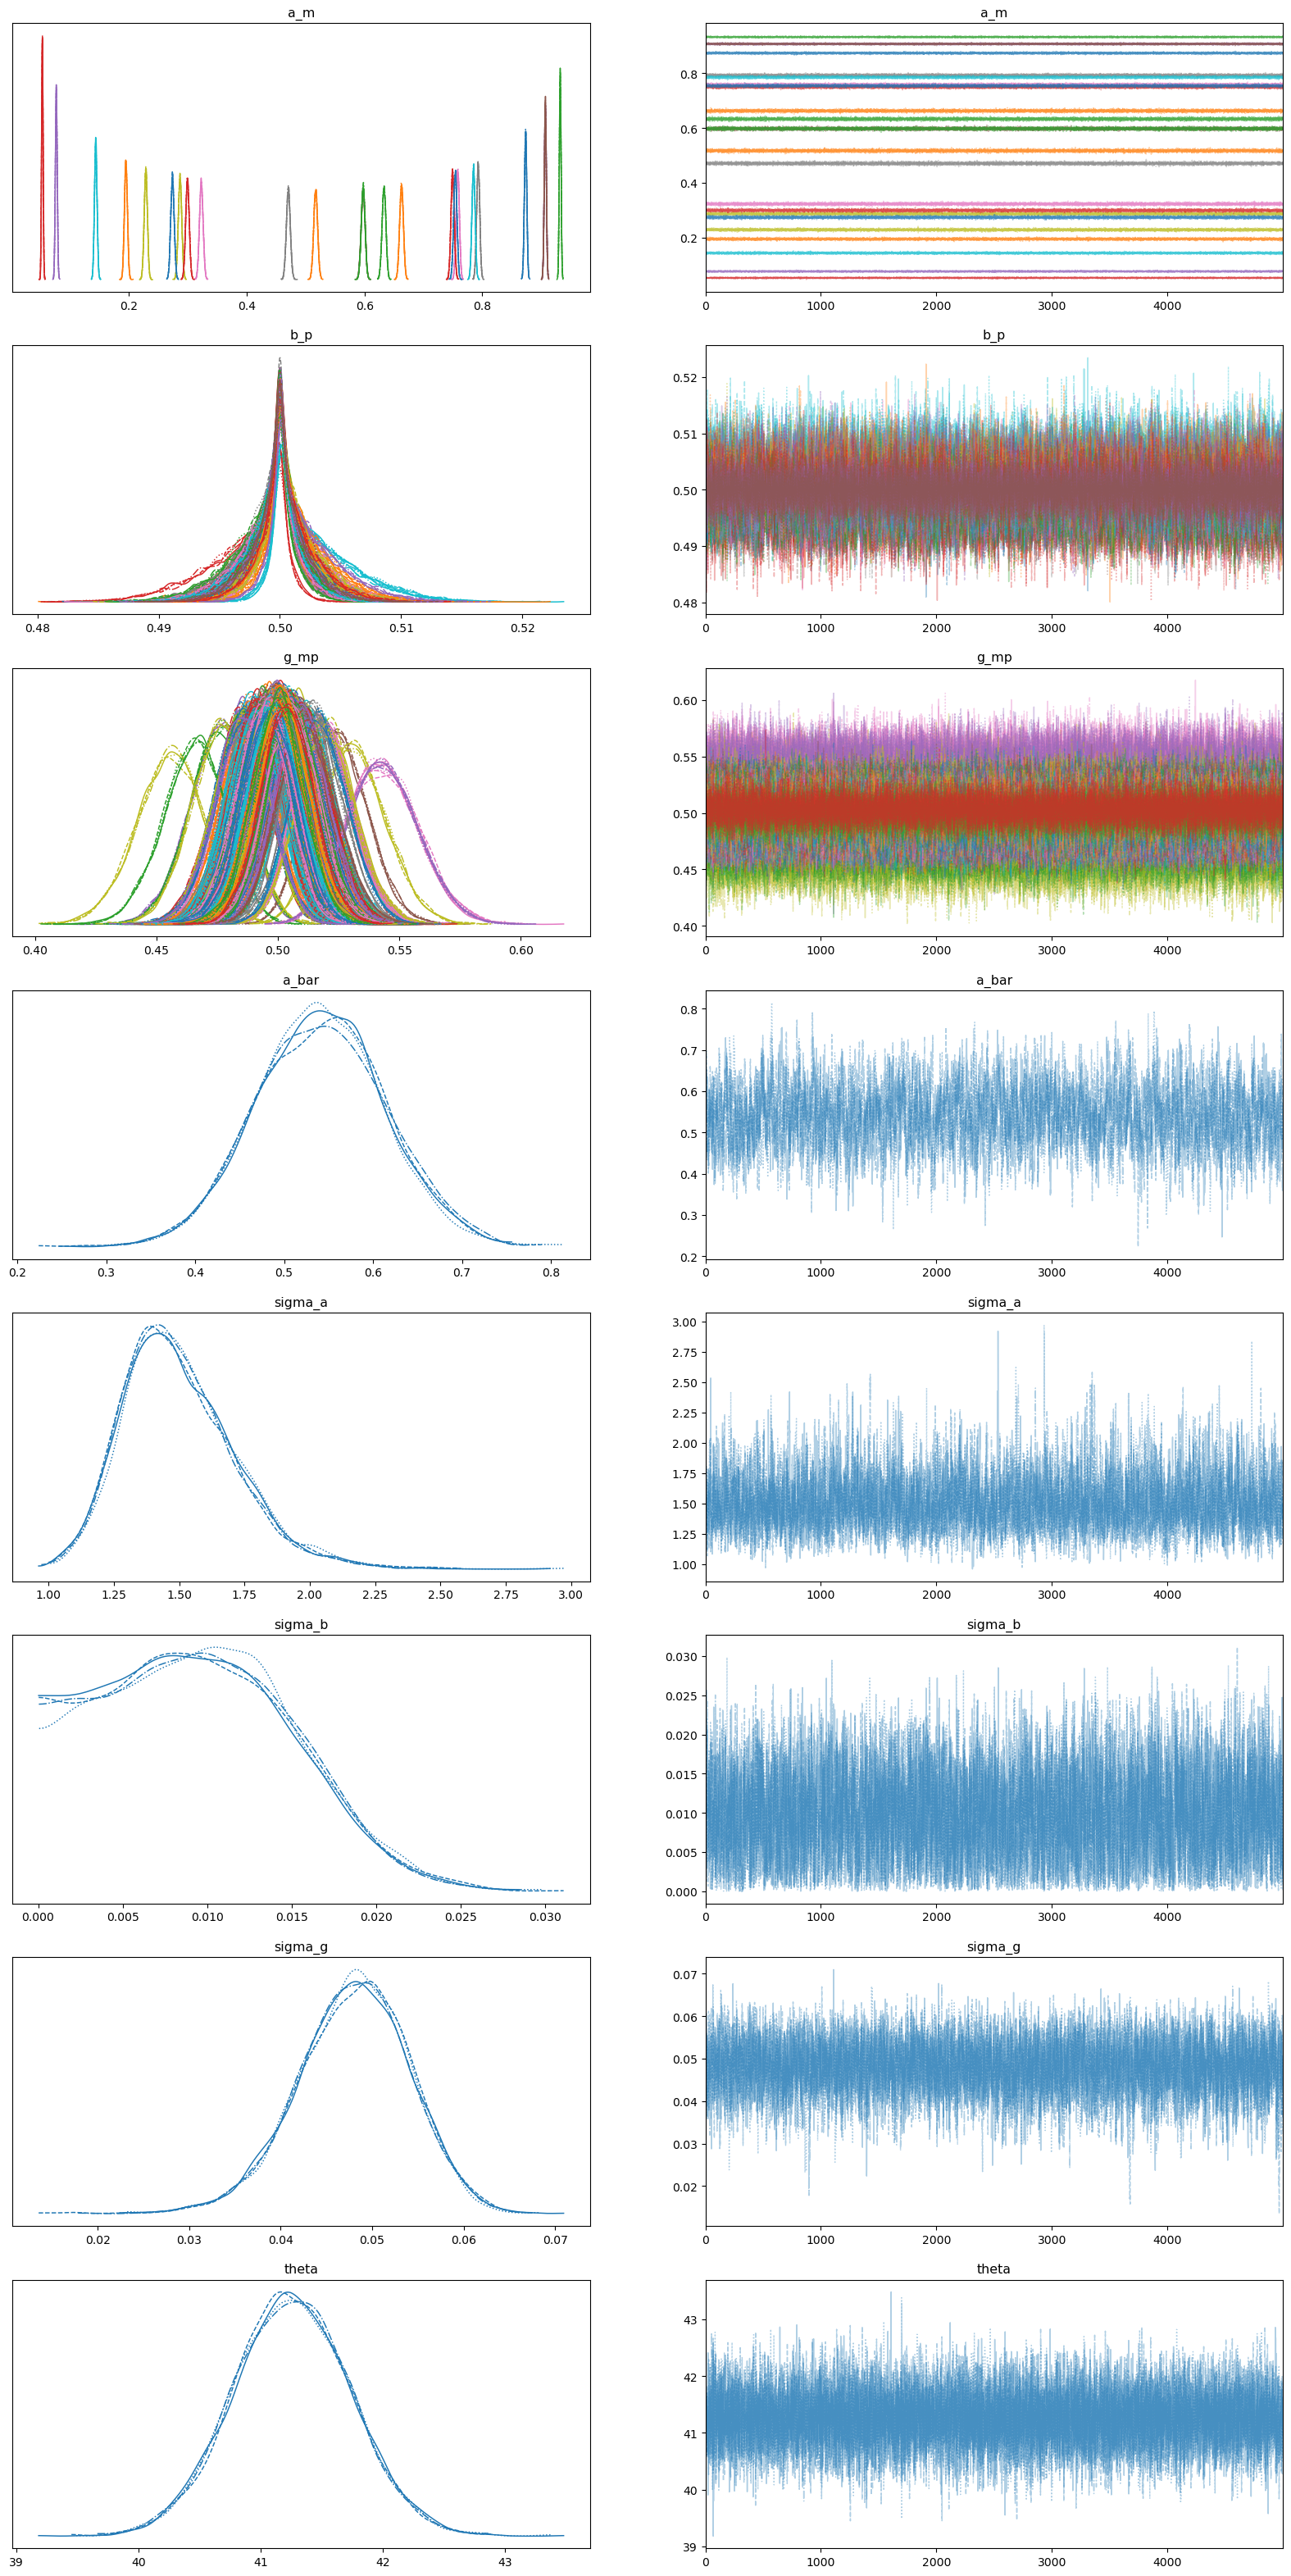

In [10]:
az.plot_trace(idata_transformed, var_names=variable_list, figsize=(20, 40))